In [99]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine 

In [100]:
#PostgresSQL connection
db_params ={
    "host":"*****",
    "database":"**",
    "user":"*****",
    "password":"****"
}

#create a connection
conn = psycopg2.connect(**db_params)

#create a Sqlalchemy engine
engine = create_engine(f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}/{db_params['database']}")

In [101]:
# Import data
df = pd.read_csv(r"C:\Users\Aayushi\Downloads\news_feature.csv")
df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [102]:
# Write the df into Postgre table
df.to_sql('news_portal', engine, if_exists = 'replace', index= False)

100

In [103]:
# Explore the dataset
q1 = """ 
select * from news_portal
"""
df_q1 = pd.read_sql_query(q1, conn)
df_q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\1393985198.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q1 = pd.read_sql_query(q1, conn)


In [104]:
df_q1

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish
...,...,...,...,...,...,...
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish


In [105]:
# Check for missing values
df.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

In [106]:
# Ditribution of users in each group
q2 = """ 
    select 
        count(distinct user_id) ,
        "group"
    from news_portal
    group by "group" 
    """
df_q2 = pd.read_sql_query(q2, conn) 
df_q2

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\2094741183.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q2 = pd.read_sql_query(q2, conn)


,count,group
0,50,control
1,50,treatment


In [107]:
# Average time spent on each landing page 
q3 = """ 
    select avg(time_spent_on_the_page), landing_page
    from news_portal
    group by landing_page
"""
df_q3 = pd.read_sql_query(q3, conn)
df_q3

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\2895663759.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q3 = pd.read_sql_query(q3, conn)


,avg,landing_page
0,4.5324,old
1,6.2232,new


In [108]:
# Conversion count for each landing page
q4 = """ 
    select 
        sum(case 
                when converted = 'yes' then 1
                else 0 
                end) as conversion_count,
        landing_page
    from news_portal
    group by landing_page
"""
df_q4 = pd.read_sql_query(q4, conn)
df_q4

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\148455552.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q4 = pd.read_sql_query(q4, conn)


,conversion_count,landing_page
0,21,old
1,33,new


In [109]:
# Conversion rate for eachh landing page
q5 = """ 
    select 
        landing_page,
        count(distinct user_id) as total_users,
        count(case
                when converted = 'yes' then 1
                else null
                end)as conversions,
        (count(case when converted = 'yes' then 1 else null end)::decimal/ count(distinct user_id)) as conversion_rate
    from news_portal
    group by landing_page
"""
df_q5 = pd.read_sql_query(q5, conn)
df_q5

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\837663608.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q5 = pd.read_sql_query(q5, conn)


,landing_page,total_users,conversions,conversion_rate
0,new,50,33,0.66
1,old,50,21,0.42


In [110]:
# Conversion rate for each page by preferred language
q6 = """ 
    select
        language_preferred,
        landing_page,
        avg(case when converted = 'yes' then 1 
                else 0 end) as conversion_lang
    from news_portal
    group by landing_page, language_preferred
    order by language_preferred
"""
df_q6 = pd.read_sql_query(q6, conn)
df_q6

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\1799021087.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q6 = pd.read_sql_query(q6, conn)


,language_preferred,landing_page,conversion_lang
0,English,new,0.625000
1,English,old,0.687500
2,French,new,0.705882
3,French,old,0.176471
4,Spanish,new,0.647059
5,Spanish,old,0.411765


In [111]:
# Mean time spent on new landing page by peferred language
q7 = """ 
    select
        language_preferred,
        avg(time_spent_on_the_page) as mean_time_spent
    from news_portal
    where landing_page = 'new'
    group by language_preferred
    order by language_preferred 
"""
df_q7 = pd.read_sql_query(q7, conn)
df_q7

C:\Users\Aayushi\AppData\Local\Temp\ipykernel_18016\3133934697.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q7 = pd.read_sql_query(q7, conn)


,language_preferred,mean_time_spent
0,English,6.663750
1,French,6.196471
2,Spanish,5.835294


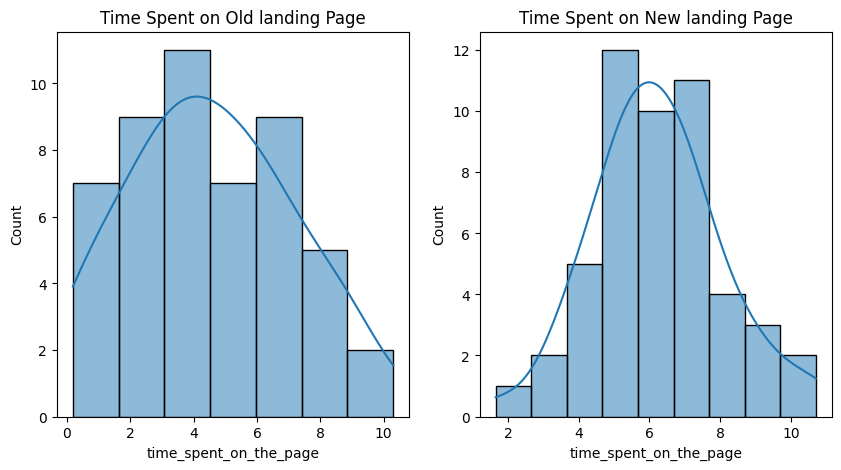

In [112]:
# Visualize the distribution
# Time spent on old vs new
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot for Old Landing Page
sns.histplot(data = df[df['landing_page'] == 'old'],
             x = 'time_spent_on_the_page',
             kde = True,
             ax = ax1)
ax1.set_title('Time Spent on Old landing Page')

# Plot fro new landing page
sns.histplot(data = df[df['landing_page'] == 'new'],
             x = 'time_spent_on_the_page',
             kde = True,
             ax = ax2)
ax2.set_title('Time Spent on New landing Page')

plt.show()

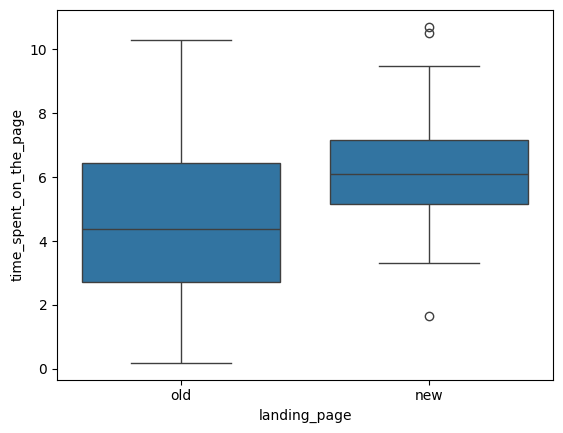

In [113]:
sns.boxplot(x ='landing_page', y= 'time_spent_on_the_page', data= df)
plt.show()

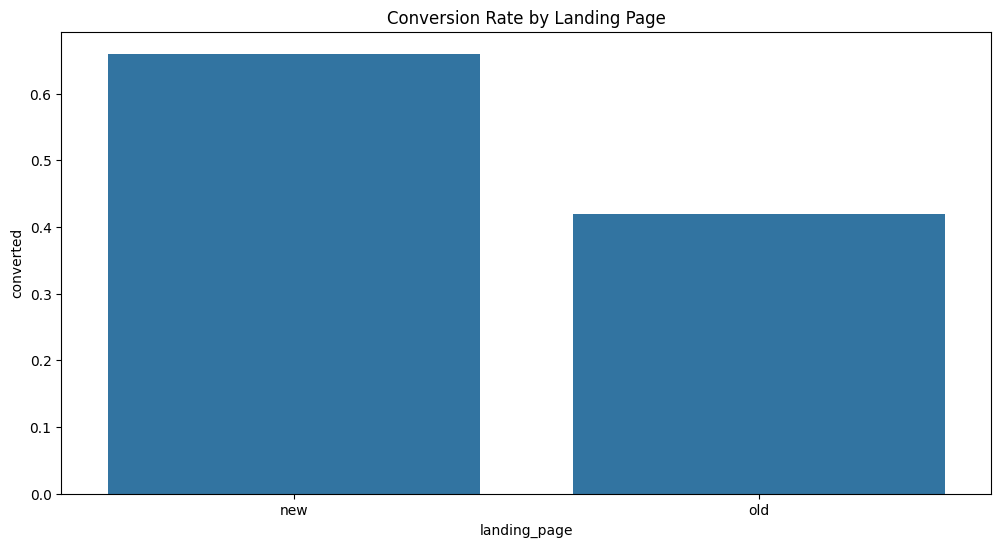

In [114]:
# Conversion rate 
# Convert convertedd column to numerical values
df['converted'] = df['converted'].apply(lambda x: 1 if x == 'yes' else 0)
conversion_rate = df.groupby('landing_page')['converted'].mean().reset_index()

# Bar plot for visualize conversion rate on both landing pages
plt.figure(figsize=(12,6))
sns.barplot(data=conversion_rate, 
         x = 'landing_page',
         y = 'converted')
plt.title('Conversion Rate by Landing Page')
plt.show()

In [115]:
# Hypothesis Testing

# Perform Mann-Whitney U Test for -Do the users spend more time on the new landing page than the old landing page?
# Distribution is not normal in both landing page so non-parametric test will be a good approach 
# Import the library
from scipy import stats

# Formulate Hypotheses
# Null Hypothesis H0 : There is no significant difference in time spent b/w new page and old page
# Alternate Hypothesis H1 : There is a significant difference in tiem spent b/w new page and old page
old_page_time = df[df['landing_page'] == 'old']['time_spent_on_the_page']
new_page_time = df[df['landing_page'] == 'new']['time_spent_on_the_page']

# Calculate medians for measuring central tendency
print(f"Median of time spent for old page: {old_page_time.median()}")
print(f"Median of time spent for new page: {new_page_time.median()}")
# Mann-Whitney U test
alpha = 0.05
statistics, p_value = stats.mannwhitneyu(old_page_time, new_page_time, alternative = 'two-sided')

print("\nTest Result-")
print(f"Mann-Whitney U test statistics: {statistics}")
print(f"p-value: {p_value}")

Median of time spent for old page: 4.38
Median of time spent for new page: 6.105

Test Result-
Mann-Whitney U test statistics: 747.0
p-value: 0.0005317974140933516


In [116]:
# Perform Chi-Square test for- Is the conversion rate (the proportion of users who visit the landing page and get converted)
# for the new page greater than the conversion rate for the old page?

# Define Hypotheses
# Null Hypothesis H0: The conversion rate of old page is equal to the conversion rate of new page
# Alternate Hypothesis H1: The conversion rate of new page is greater than converssion rate of old page

# Create contigency table
contingency_table = pd.crosstab(df['landing_page'], df['converted'])
print(contingency_table)

# Perform Chi2 test
import numpy as np
from scipy.stats import chi2_contingency
alpha = 0.05
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

one_tailed_p_val = p_value /2 

print("\nTest Result-")
print(f"Chi-Square statistics: {chi2}")
print(f"p-value: {one_tailed_p_val}")
print(f"Degree of Freedom: {dof}")


converted      0   1
landing_page        
new           17  33
old           29  21

Test Result-
Chi-Square statistics: 4.871175523349437
p-value: 0.01365444587746116
Degree of Freedom: 1


In [117]:
# Perform Chi-Square test for - Does the converted status depend on the preferred language?
# Define Hypotheses
# Null Hypothesis H0: There is no significant realationship between a user preferred language and conversion rate.
# Alternate Hypothesis H1: There is a significant relationship betweeen  user preferred language and conversion rate.

# Create contigency table
contingency_t2 = pd.crosstab(df['language_preferred'], df['converted'])
print(contingency_t2)

# Perform Chi2 test
alpha = 0.05
chi2, p_value, dof, expected = chi2_contingency(contingency_t2)

print("\nTest Result-")
print(f"Chi-Square Statistics: {chi2}")
print(f"p-value: {p_value}")
print(f"Degree of Freedom: {dof}")


converted            0   1
language_preferred        
English             11  21
French              19  15
Spanish             16  18

Test Result-
Chi-Square Statistics: 3.0930306905370832
p-value: 0.2129888748754345
Degree of Freedom: 2


In [118]:
# Perform ANOVA for- Is the mean time spent on the new page the same for the different language users?
# Define Hypothesis
# Null Hypothesis H0: The mean time spent is same on the new page for all language groups
# Alternate Hypothesis H1: The mean time spent on the new page is different for atleast one language group

# Filter for new page
newpage_u = df[df['landing_page'] == 'new']

# perform ANOVA test
alpha = 0.05
f_stat , p_vlaue = stats.f_oneway(*[lang['time_spent_on_the_page'].values for name, lang in newpage_u.groupby('language_preferred')])

print("\nTest Result-")
print(f"ANOVA test Statistics: {f_stat}")
print(f"p-value: {p_value}")



Test Result-
ANOVA test Statistics: 0.8543992770006822
p-value: 0.2129888748754345


CONCLUSION

1. Mann-Whitney U test for time spent on new vs. old page

Test statistic: 747.0
p-value: 0.0005317974140933516
Result: With a p-value of approximately 0.00053, which is much less than significance level of 0.05, we reject the null hypothesis. 
There is strong evidence to suggest a significant difference in time spent between the new page and the old page. 
Given that the median time for the new page (6.105) is higher than the old page (4.38), we can conclude that users tend to spend more time on the new page compared to the old page.

2. Chi-Square test for conversion rates

Chi-Square statistic: 4.871175523349437
p-value: 0.01365444587746116
Degrees of freedom: 1
Conclusion: The p-value of approximately 0.0137 is less than the significance level of 0.05. Therefore, we reject the null hypothesis. 
There is sufficient evidence to conclude that the conversion rate of the new page is significantly greater than the conversion rate of the old page. 
This suggests that the new page design is more effective in converting users.

3. Chi-Square test for relationship between user preferred language and conversion rate

Chi-Square statistic: 3.0930306905370832
p-value: 0.2129888748754345
Degrees of freedom: 2
Conclusion: The p-value of approximately 0.2130 is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis. 
There is not enough evidence to conclude that there is a significant relationship between a user's preferred language and the conversion rate.
This suggests that the conversion rate is not significantly affected by the user's language preference.

4. ANOVA test for mean time spent on new page across language groups

ANOVA test statistic: 0.8543992770006822
p-value: 0.2129888748754345
Conclusion: The p-value of approximately 0.2130 is greater than the significance level of 0.05. Therefore, we fail to reject the null hypothesis. 
There is not enough evidence to conclude that the mean time spent on the new page differs significantly among the language groups. This suggests that users from different language groups spend, on average, similar amounts of time on the new page.


Finally, these results indicate that the new page design leads to increased time spent and higher conversion rates compared to the old page, regardless of the user's preferred language. The user's language preference does not seem to significantly impact conversion rates or time spent on the new page.